# 13-9. 프로젝트 : 주식 예측에 도전해 보자

주식 데이터를 ARIMA를 통해서 예측해보겠습니다. 

데이터 출처 [야후 FINANCE](https://finance.yahoo.com/)

삼성전자, 넷플릭스, 나스닥에 대해서 예측하도록 하겠습니다.


평가 기준은 아래와 같습니다.

1. 시계열의 안정성이 충분히 확인되었는가?

플로팅과 adfuller 메소드가 모두 적절히 사용되었음

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨


# 시작하기 전에 

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math

In [119]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [120]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


# 데이터 준비

In [194]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [195]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735.0
2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683.0
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879.0


In [196]:
ts.tail()

Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

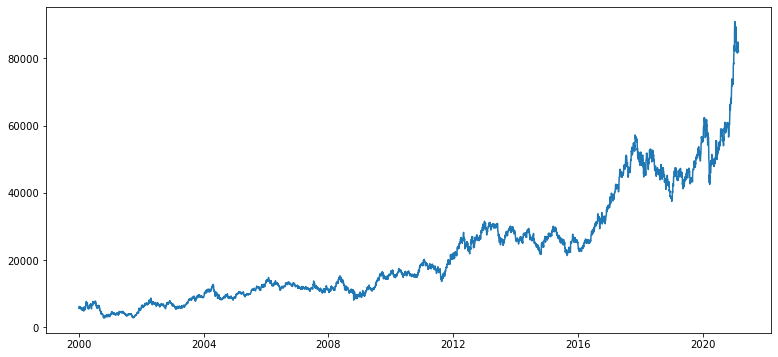

In [197]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [198]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [200]:
ts_log = np.log(ts)

꾸준히 성장한 삼성전자기 때문에 log를 통해서 안정화를 시켜줍니다.

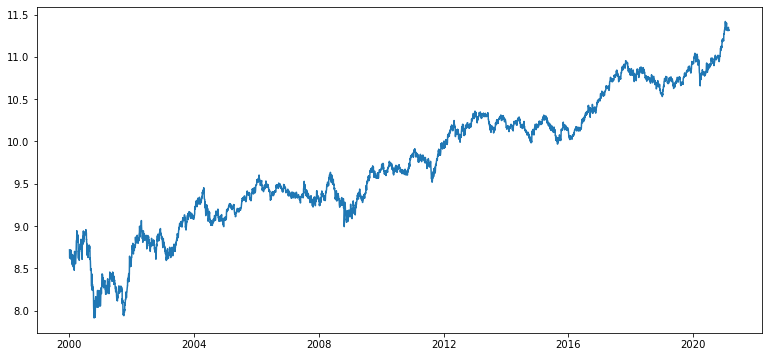

In [128]:
plt.plot(ts_log)

# stationary 검정

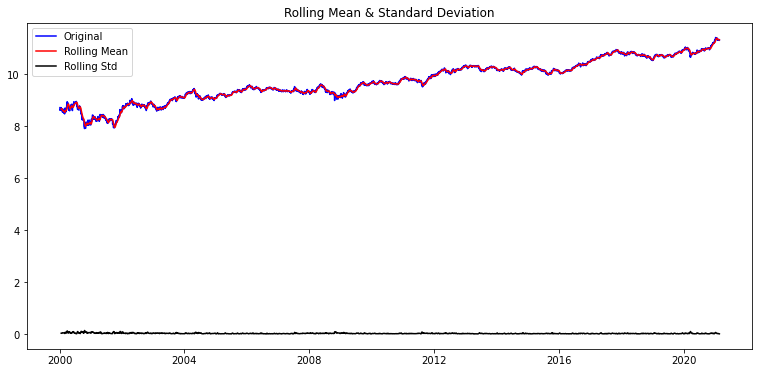

Results of Dickey-Fuller Test:
Test Statistic                   -0.327864
p-value                           0.921464
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


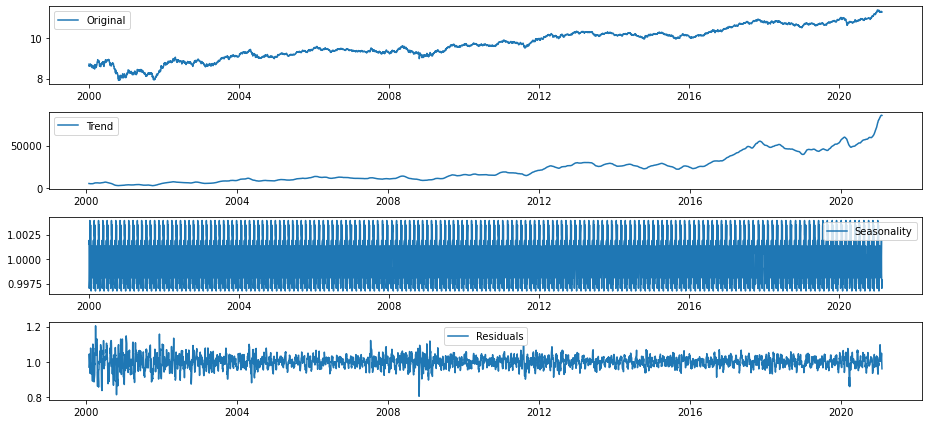

In [129]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [130]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.730868e+01
p-value                        5.571623e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있습니다. 
사실 stationary를 검정하는 테스트는 더 많지만 이 분석에서는 여기 까지 하겠습니다.

# train, test 데이터 분리

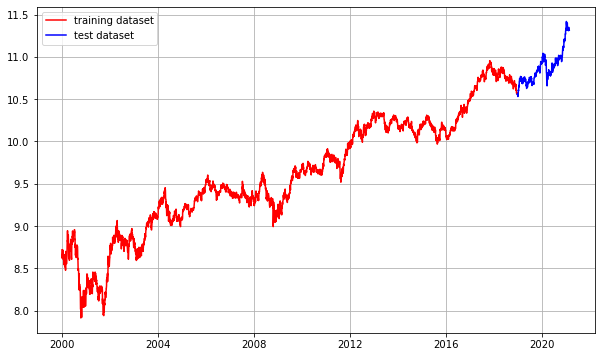

In [131]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.9)], ts_log[int(len(ts_log)* 0.9 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


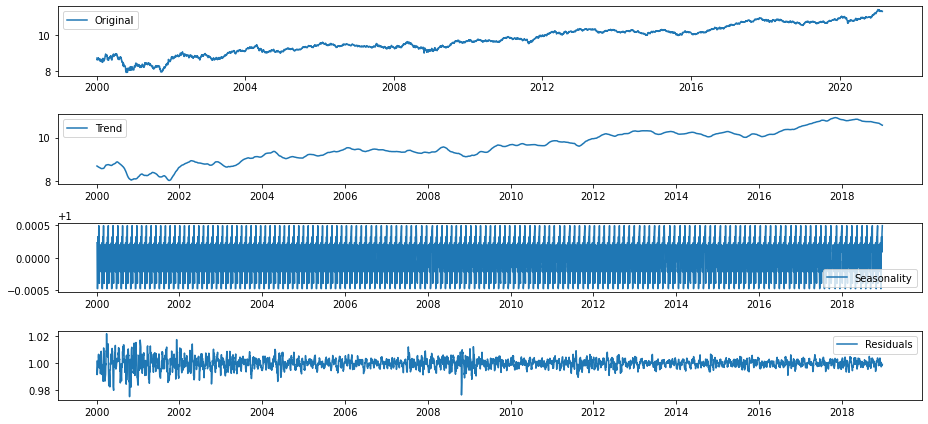

In [132]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data, model='multiplicative', period = 30, extrapolate_trend = 1)
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [133]:
trend

Date
2000-01-04     8.702291
2000-01-05     8.697774
2000-01-06     8.693257
2000-01-07     8.688740
2000-01-10     8.684223
                ...    
2018-12-18    10.586542
2018-12-19    10.582088
2018-12-20    10.577635
2018-12-21    10.573181
2018-12-24    10.568728
Name: trend, Length: 4783, dtype: float64

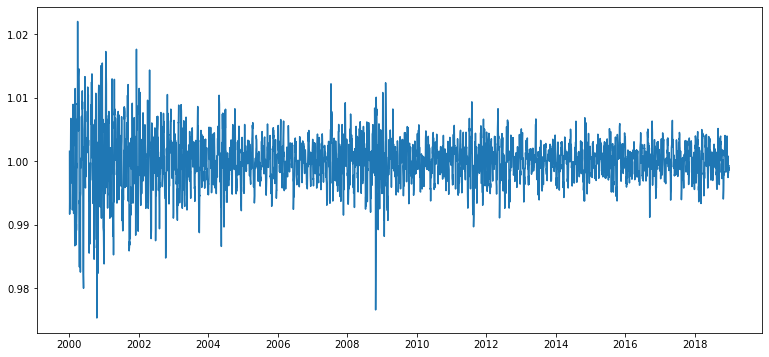

In [134]:
plt.plot(residual)

In [135]:
# ts = ts.interpolate(method = 'time')
residual[residual.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: resid, dtype: float64)

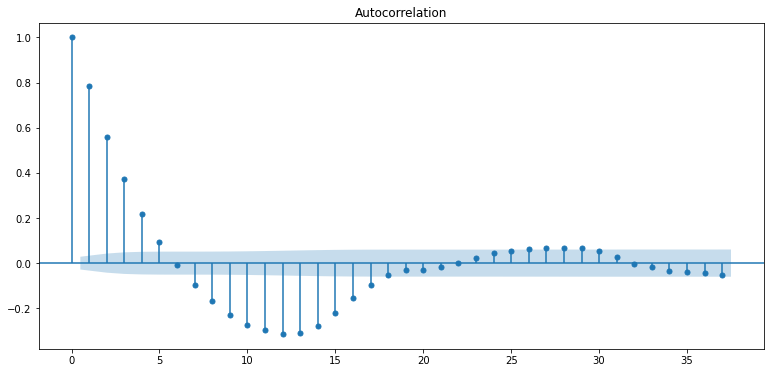

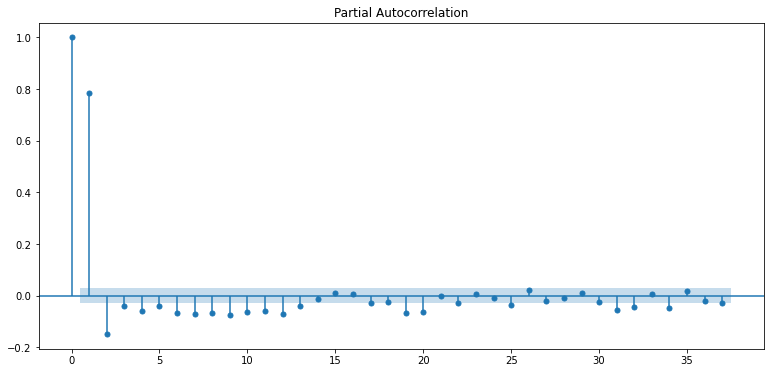

In [136]:
plot_acf(residual)
plot_pacf(residual)
plt.show()

만약 residual에 대해서 arima 모델을 적합시킨다면 pacf와 acf를 봤을때 ar(1)이나 ar(2)가 적절해보입니다. 

하지만 사실 pacf, acf를 통해서 arima모델의 패러미터를 구하는 방법은 연구자의 감으로 결정하는 것이기 때문에         
사용하기 어렵기도 합니다. 그렇기 때문에 AIC,BIC를 계산하여 패러미터를 지정하기도하고

예측력에 초점을 둔다면 TEST data을 대상으로 가장 좋은 성능을 보인 패러미터를 지정하기도합니다.                   
이번 제 노드의 목적은 예측이기때문에 가장 낮은 MAPE를 보인 패러미터를 지정하도록 하겠습니다.

### 차분 

Data를 차분을 통해서 stationary를 얻을 수 도 있습니다. 예시는 아래와 같습니다.         
차분한 후에도 pacf, acf를 통해서 모델을 설정할수있습니다.

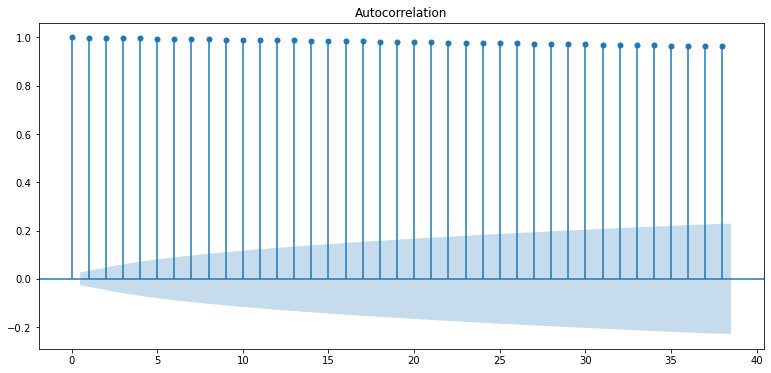

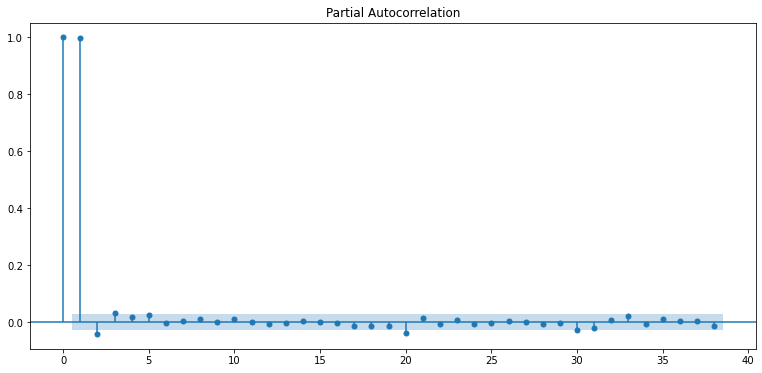

In [201]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.092467
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


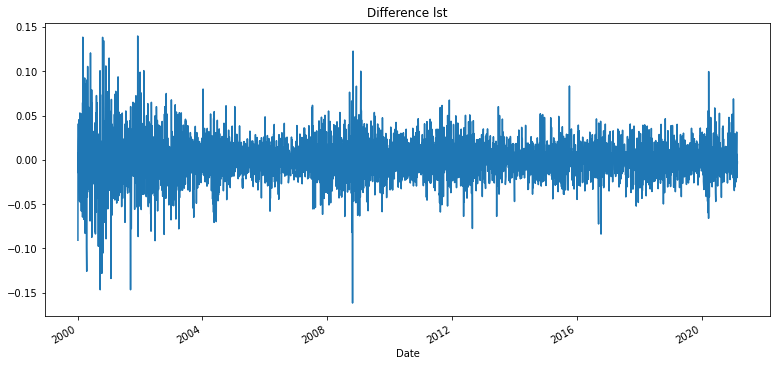

In [202]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

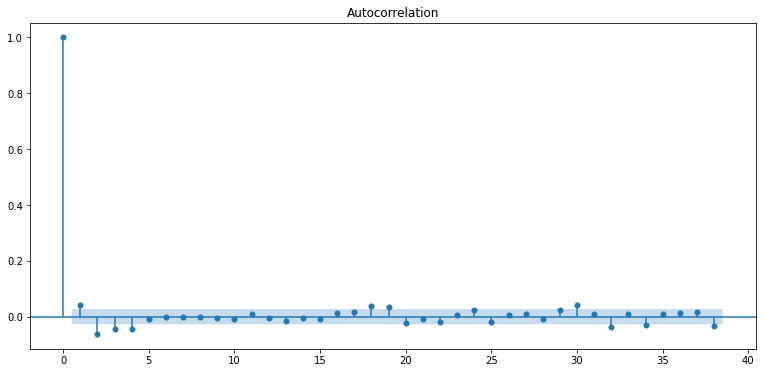

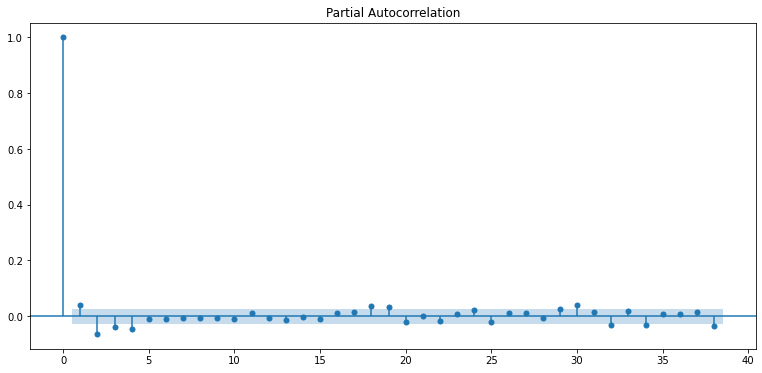

In [203]:

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -21.807706
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5279.000000
Critical Value (1%)              -3.431589
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


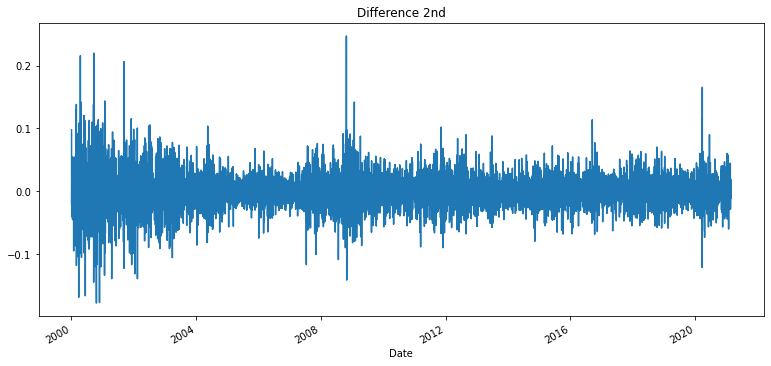

In [204]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

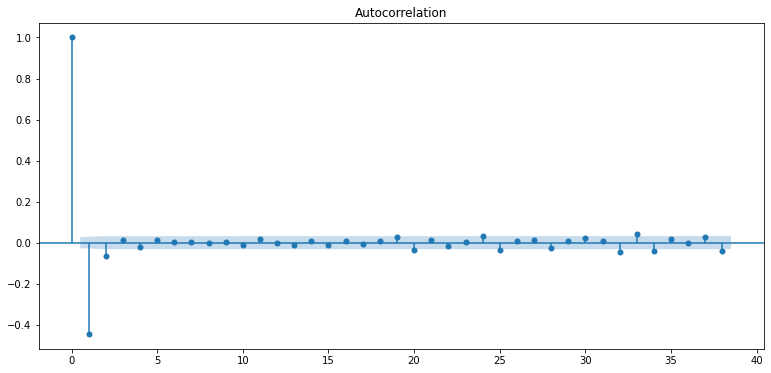

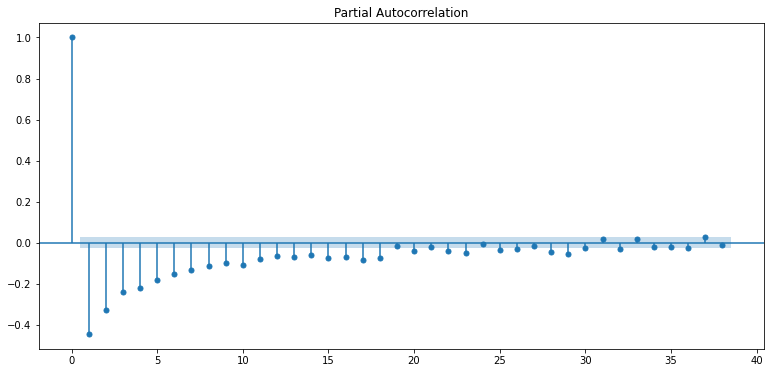

In [205]:
plot_acf(diff_2)
plot_pacf(diff_2)
plt.show()

하지만 저는 exog 변수를 통해서 분석할 것이기때문에 차분 역시 하지 않겠습니다.     
일반적으로 차분을 통해서 안정화시키는 경우 계절성을 제거하기위해서 자주 사용하는데(이를 SARIMA모델이라고 부름)         
이때 대수의 원리에 따라 계절성을 제거하면 트렌드  역시  제거된다는 것을 명심해야합니다. 



# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



### power transformation 사용 

분산을 안정화시키고 정규분포에 가깝게 근사시키기 위해서 사용하는 power함수를 사용하는 단조함수들을 통한 변환입니다.        
log변환 역시 일종의 power transforamtion이라고 볼 수 있습니다.

[위키디피아](https://en.wikipedia.org/wiki/Power_transform)

[scipy boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
[scipy boxcox의 인버스](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html)

In [139]:
from scipy.stats import boxcox

In [140]:
ts

Date
2000-01-04     6110.0
2000-01-05     5580.0
2000-01-06     5620.0
2000-01-07     5540.0
2000-01-10     5770.0
               ...   
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, Length: 5315, dtype: float64

In [141]:
powerd  = boxcox(ts)
ts_power, lamda = powerd
print(type(ts_power))
print(ts_power)

len(ts_power)

<class 'numpy.ndarray'>
[10.87481865 10.73605457 10.74695571 ... 15.13178665 15.12333519
 15.11909478]


5315

In [142]:
ts_power = pd.Series(ts_power, index = ts.index)
ts_power

Date
2000-01-04    10.874819
2000-01-05    10.736055
2000-01-06    10.746956
2000-01-07    10.725079
2000-01-10    10.787188
                ...    
2021-02-17    15.144391
2021-02-18    15.121216
2021-02-19    15.131787
2021-02-22    15.123335
2021-02-23    15.119095
Length: 5315, dtype: float64

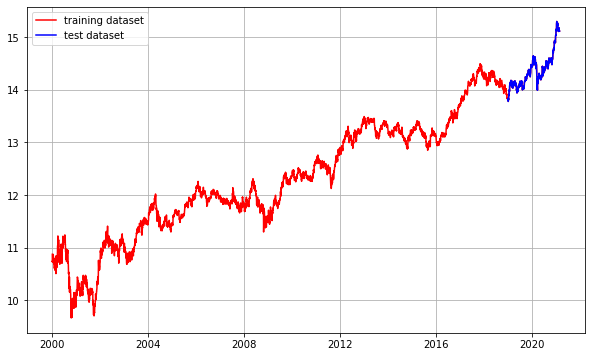

In [143]:
train_data, test_data = ts_power[ : int(len(ts_power)*0.90)],ts_power[int(len(ts_power)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_power, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

사실 안타깝게도 대부분의 데이터에서 box-cox transformation 변환이
아래의 log 변환보다 성능이 좋지않았습니다. 

그러므로 아래에서는 사용하지않곘습니다.

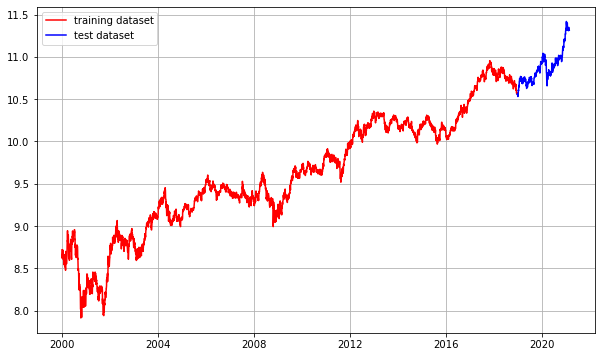

In [146]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.90)],ts_log[int(len(ts_log)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

### exog 변수 추가 

높은 정확도를 위해서 외래변수를 추가합니다. 저는 종가 데이터를 예측하기위해서
시가 데이터를 exog로 추가하도록하겠습니다.

In [149]:
Open = df['Open']
# Open = np.log(Open)
open_train, open_test = Open[ : int(len(ts_power)*0.90)]  , Open[int(len(ts_power)* 0.90 ): ]
open_train = open_train.interpolate(method = 'time')
open_test = open_test.interpolate(mothod = 'time')

In [150]:
train_data = train_data.interpolate(method = 'time')

In [151]:
open_test[open_test.isna()]


Series([], Name: Open, dtype: float64)

In [152]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (12,0,0), exog = open_train)
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4783
Model:                    ARMA(12, 0)   Log Likelihood               11524.157
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 02 Mar 2021   AIC                         -23018.313
Time:                        03:42:37   BIC                         -22921.221
Sample:                             0   HQIC                        -22984.207
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.2912      0.191     48.660      0.000       8.917       9.665
Open          2.088e-05   9.34e-07     22.346      0.000     1.9e-05    2.27e-05
ar.L1.Close      0.8405      0.017     48.96

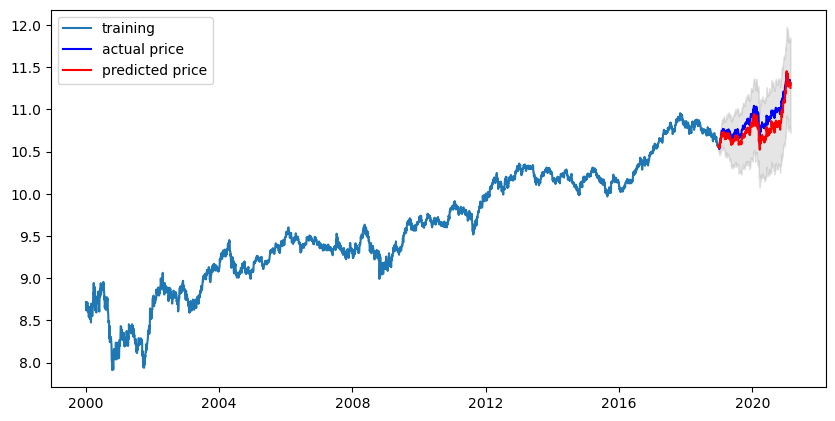

In [153]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(open_test), alpha = 0.05, exog = open_test) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34617269.27732541
MAE:  5208.099432587495
RMSE:  5883.644217432374
MAPE: 9.57%


exog 변수 덕분에 좋은 성능을 보일 수 있었습니다.

``` python
mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))
```

의 코드는 시계열 데이터를 box-cox 변환 했을때의 MAPE를 계산하기 위해 만들어놓은 식입니다.

# STEP 7 : 다른 주식 종목 예측해 보기

# 넷플릭스 

# 데이터 준비

In [157]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2002-05-23    1.196429
2002-05-24    1.210000
2002-05-28    1.157143
2002-05-29    1.103571
2002-05-30    1.071429
Name: Close, dtype: float64

In [158]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...
2021-02-16,557.289978,563.630005,552.729980,557.280029,557.280029,2622400
2021-02-17,550.989990,555.250000,543.030029,551.340027,551.340027,2069600
2021-02-18,549.000000,550.000000,538.229980,548.219971,548.219971,2456200


In [159]:
ts.tail()

Date
2021-02-16    557.280029
2021-02-17    551.340027
2021-02-18    548.219971
2021-02-19    540.219971
2021-02-22    533.780029
Name: Close, dtype: float64

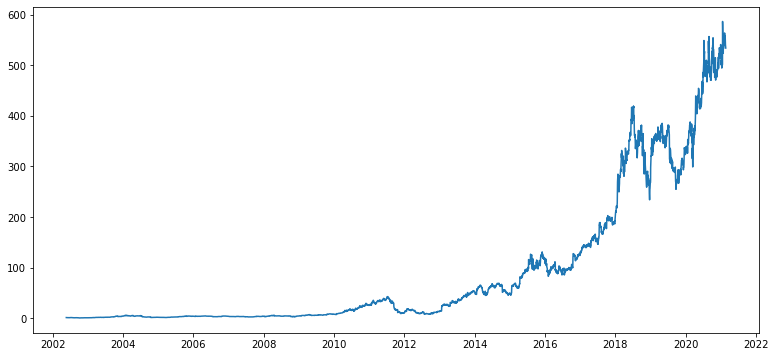

In [161]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [162]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [163]:
ts_log = np.log(ts)

역시 FANG으로 고성장하고 있는 neflix이기때문에 log를 통해 안정화시켜줍니다.

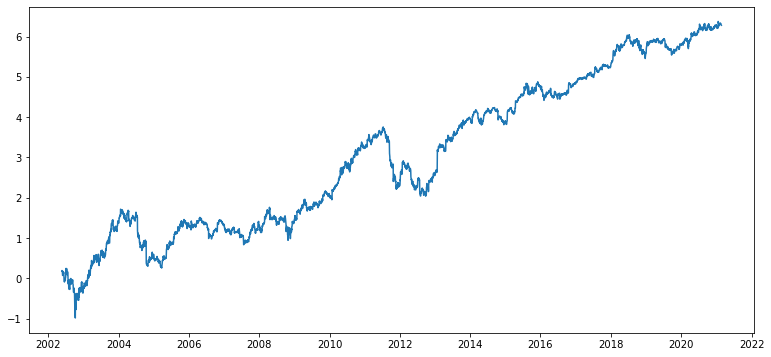

In [165]:
plt.plot(ts_log)

# stationary 검정

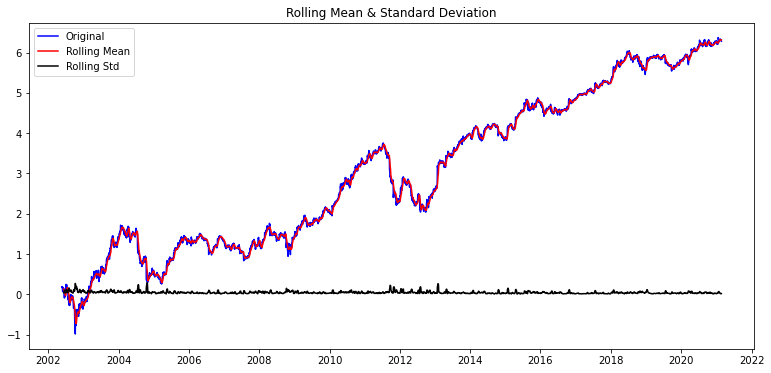

Results of Dickey-Fuller Test:
Test Statistic                   -0.418443
p-value                           0.906974
#Lags Used                        1.000000
Number of Observations Used    4718.000000
Critical Value (1%)              -3.431737
Critical Value (5%)              -2.862153
Critical Value (10%)             -2.567096
dtype: float64


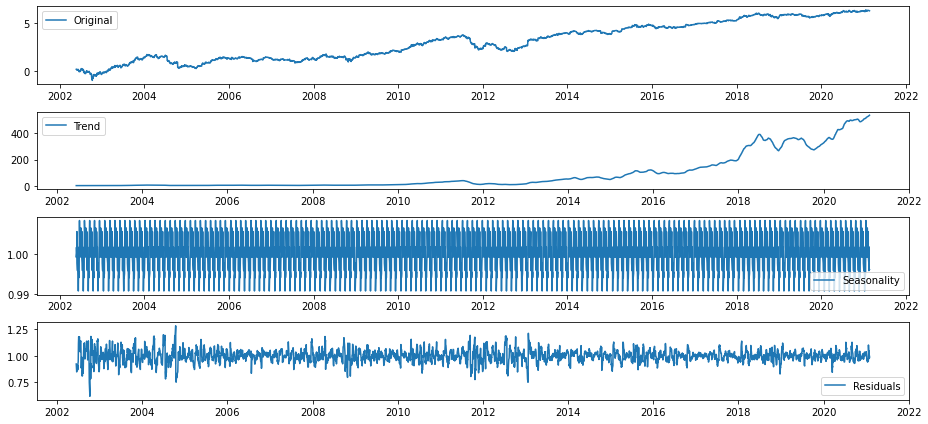

In [166]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [167]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.641180e+01
p-value                        2.579421e-29
#Lags Used                     3.200000e+01
Number of Observations Used    4.657000e+03
Critical Value (1%)           -3.431755e+00
Critical Value (5%)           -2.862161e+00
Critical Value (10%)          -2.567100e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있습니다. 
사실 stationary를 검정하는 테스트는 더 많지만 이 분석에서는 여기 까지 하겠습니다.

# train, test 데이터 분리

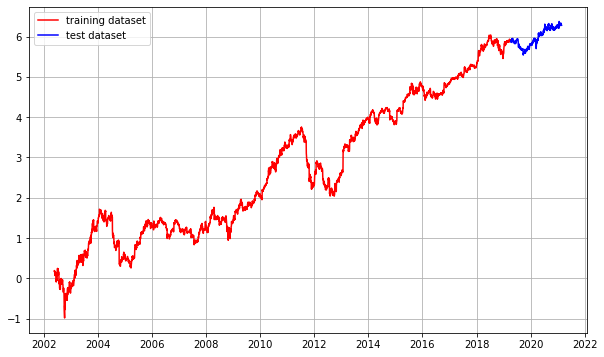

In [168]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.9)], ts_log[int(len(ts_log)* 0.9 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


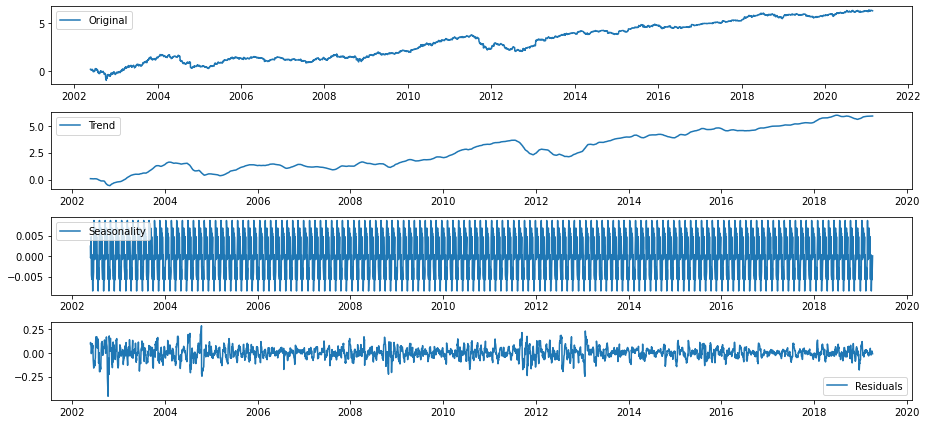

In [170]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data, model='additve', period = 30, extrapolate_trend = 1)
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [171]:
trend

Date
2002-05-23    0.083031
2002-05-24    0.082047
2002-05-28    0.081062
2002-05-29    0.080078
2002-05-30    0.079094
                ...   
2019-04-02    5.896513
2019-04-03    5.897128
2019-04-04    5.897742
2019-04-05    5.898357
2019-04-08    5.898972
Name: trend, Length: 4248, dtype: float64

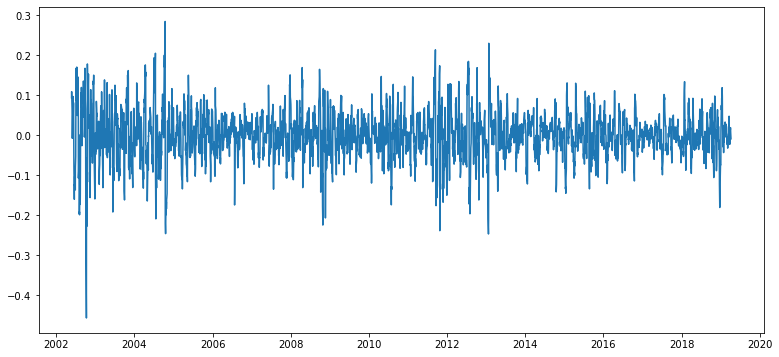

In [172]:
plt.plot(residual)

In [173]:
# ts = ts.interpolate(method = 'time')
residual[residual.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: resid, dtype: float64)

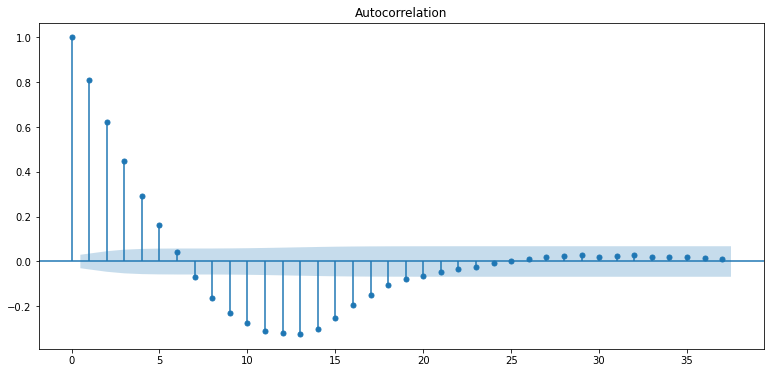

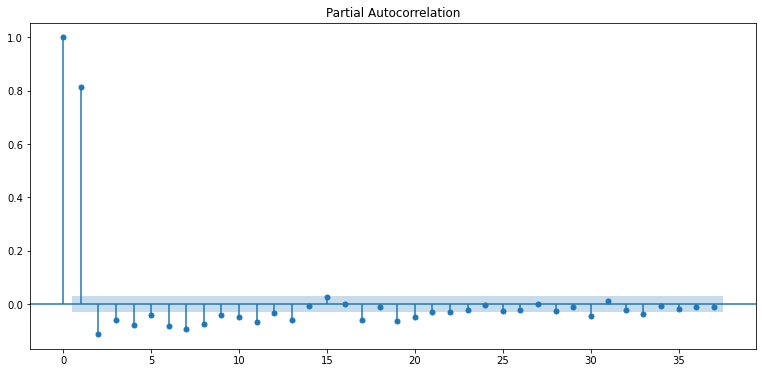

In [174]:
plot_acf(residual)
plot_pacf(residual)
plt.show()

만약 residual에 대해서 arima 모델을 적합시킨다면 pacf와 acf를 봤을때 ar(1)이 적절해보입니다. 

하지만 사실 pacf, acf를 통해서 arima모델의 패러미터를 구하는 방법은 연구자의 감으로 결정하는 것이기 때문에         
사용하기 어렵기도 합니다. 그렇기 때문에 AIC,BIC를 계산하여 패러미터를 지정하기도하고

예측력에 초점을 둔다면 TEST data을 대상으로 가장 좋은 성능을 보인 패러미터를 지정하기도합니다.                   
이번 제 노드의 목적은 예측이기때문에 가장 낮은 MAPE를 보인 패러미터를 지정하도록 하겠습니다.

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



### power transformation 사용 

분산을 안정화시키고 정규분포에 가깝게 근사시키기 위해서 사용하는 power함수를 사용하는 단조함수들을 통한 변환입니다.        
log변환 역시 일종의 power transforamtion이라고 볼 수 있습니다.

[위키디피아](https://en.wikipedia.org/wiki/Power_transform)

[scipy boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
[scipy boxcox의 인버스](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html)

In [175]:
from scipy.stats import boxcox

In [176]:
ts

Date
2002-05-23      1.196429
2002-05-24      1.210000
2002-05-28      1.157143
2002-05-29      1.103571
2002-05-30      1.071429
                 ...    
2021-02-16    557.280029
2021-02-17    551.340027
2021-02-18    548.219971
2021-02-19    540.219971
2021-02-22    533.780029
Name: Close, Length: 4720, dtype: float64

In [177]:
powerd  = boxcox(ts)
ts_power, lamda = powerd
print(type(ts_power))
print(ts_power)

len(ts_power)

<class 'numpy.ndarray'>
[0.17856892 0.18974794 0.1454422  ... 5.43883943 5.42798639 5.41912667]


4720

In [178]:
ts_power = pd.Series(ts_power, index = ts.index)
ts_power

Date
2002-05-23    0.178569
2002-05-24    0.189748
2002-05-28    0.145442
2002-05-29    0.098318
2002-05-30    0.068879
                ...   
2021-02-16    5.450932
2021-02-17    5.443027
2021-02-18    5.438839
2021-02-19    5.427986
2021-02-22    5.419127
Length: 4720, dtype: float64

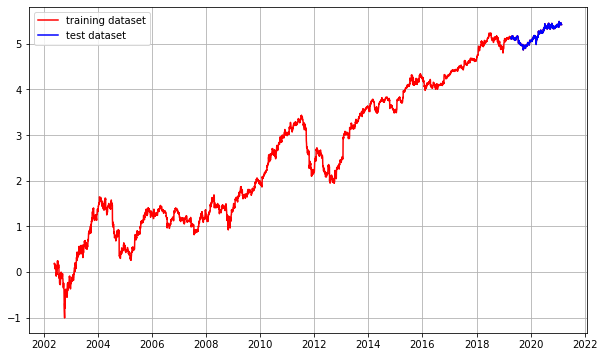

In [179]:
train_data, test_data = ts_power[ : int(len(ts_power)*0.90)],ts_power[int(len(ts_power)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_power, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

사실 안타깝게도 대부분의 데이터에서 box-cox transformation 변환이
아래의 log 변환보다 성능이 좋지않았습니다. 

그러므로 아래에서는 사용하지않곘습니다.

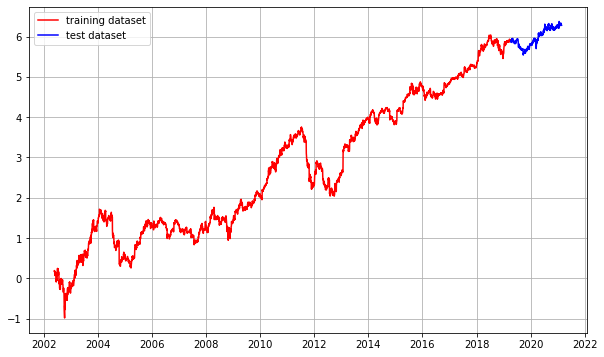

In [180]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.90)],ts_log[int(len(ts_log)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

### exog 변수 추가 

높은 정확도를 위해서 외래변수를 추가합니다. 저는 종가 데이터를 예측하기위해서
시가 데이터를 exog로 추가하도록하겠습니다.

In [184]:
Open = df['Open']
# Open = np.log(Open)
open_train, open_test = Open[ : int(len(ts_power)*0.90)]  , Open[int(len(ts_power)* 0.90 ): ]
open_train = open_train.interpolate(method = 'time')
open_test = open_test.interpolate(mothod = 'time')

In [185]:
train_data = train_data.interpolate(method = 'time')

In [186]:
open_test[open_test.isna()]


Series([], Name: Open, dtype: float64)

In [190]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (3,0,3), exog = open_train)
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4248
Model:                     ARMA(3, 3)   Log Likelihood                7980.737
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 02 Mar 2021   AIC                         -15943.473
Time:                        03:53:06   BIC                         -15886.286
Sample:                             0   HQIC                        -15923.264
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.7865        nan        nan        nan         nan         nan
Open            0.0016      0.000      8.459      0.000       0.001       0.002
ar.L1.Close     2.1453      0.001   2208.131    

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


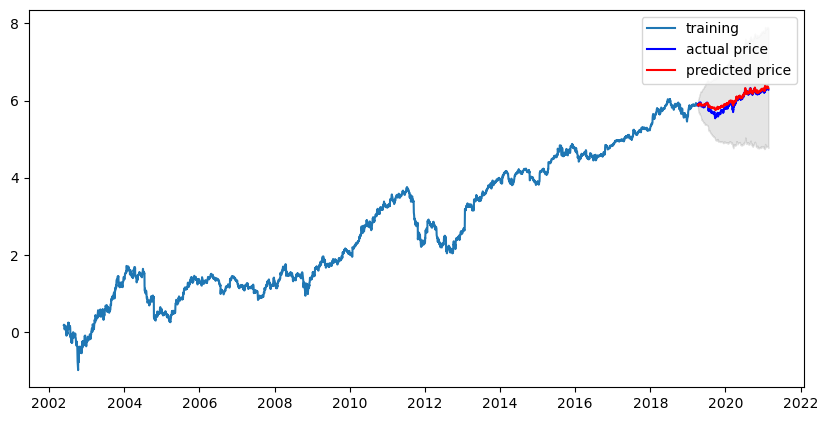

In [191]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(open_test), alpha = 0.05, exog = open_test) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [192]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  698.7984628043239
MAE:  21.28287652741032
RMSE:  26.434796439623362
MAPE: 6.15%


exog 변수 덕분에 좋은 성능을 보일 수 있었습니다.

``` python
mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))
```

의 코드는 시계열 데이터를 box-cox 변환 했을때의 MAPE를 계산하기 위해 만들어놓은 식입니다.

# STEP 7 : 다른 주식 종목 예측해 보기

# 나스닥

# 데이터 준비

In [208]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/^IXIC.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
1971-02-05    100.000000
1971-02-08    100.839996
1971-02-09    100.760002
1971-02-10    100.690002
1971-02-11    101.449997
Name: Close, dtype: float64

In [209]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...
2021-02-23,13262.610352,13526.089844,13003.980469,13465.200195,13465.200195,7482840000
2021-02-24,13400.250000,13607.360352,13286.589844,13597.969727,13597.969727,5793430000
2021-02-25,13512.639648,13602.860352,13066.379883,13119.429688,13119.429688,6335240000


In [210]:
ts.tail()

Date
2021-02-23    13465.200195
2021-02-24    13597.969727
2021-02-25    13119.429688
2021-02-26    13192.349609
2021-03-01    13509.893555
Name: Close, dtype: float64

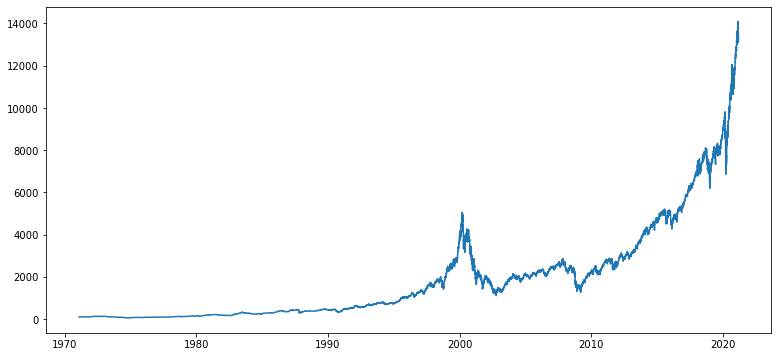

In [211]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [212]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [213]:
ts_log = np.log(ts)

역시 FANG으로 고성장하고 있는 neflix이기때문에 log를 통해 안정화시켜줍니다.

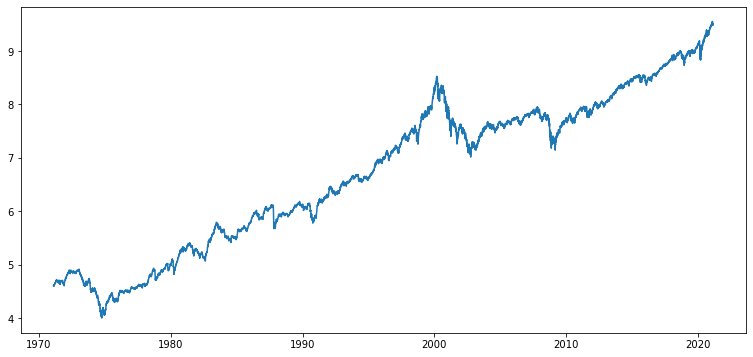

In [214]:
plt.plot(ts_log)

# stationary 검정

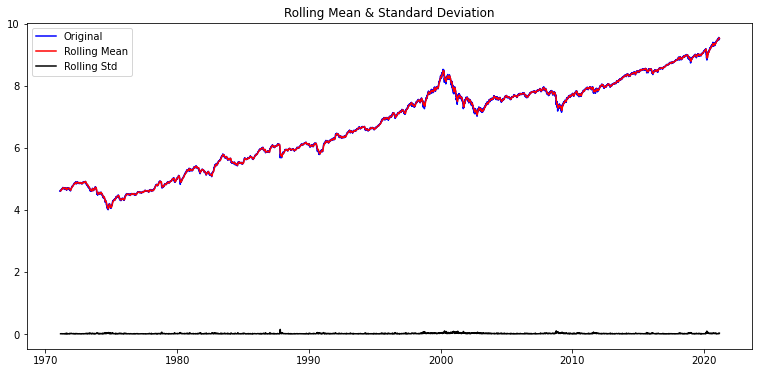

Results of Dickey-Fuller Test:
Test Statistic                     0.161058
p-value                            0.969991
#Lags Used                        40.000000
Number of Observations Used    12586.000000
Critical Value (1%)               -3.430870
Critical Value (5%)               -2.861770
Critical Value (10%)              -2.566892
dtype: float64


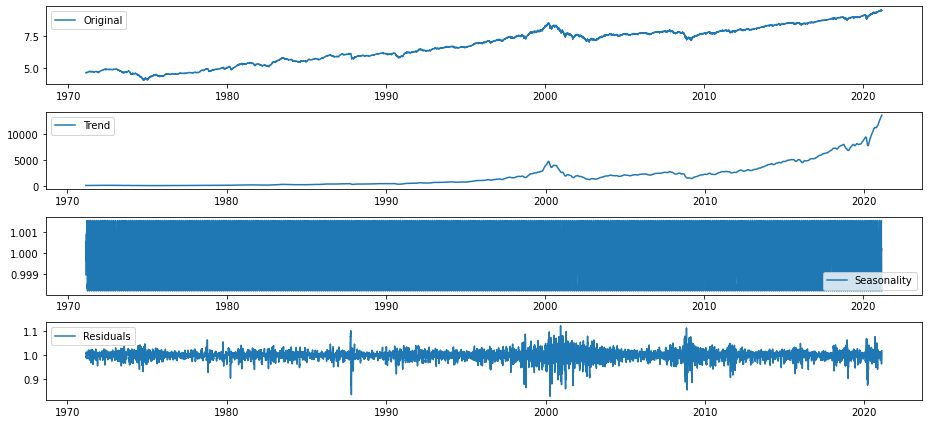

In [215]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [216]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                   -24.872813
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    12555.000000
Critical Value (1%)               -3.430871
Critical Value (5%)               -2.861770
Critical Value (10%)              -2.566893
dtype: float64


residual은 상당히 stationary함을 볼 수 있습니다. 
사실 stationary를 검정하는 테스트는 더 많지만 이 분석에서는 여기 까지 하겠습니다.

# train, test 데이터 분리

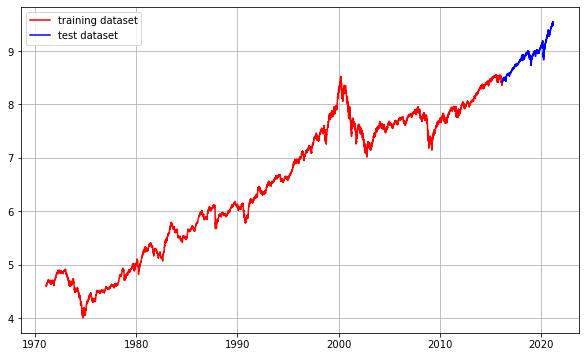

In [217]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.9)], ts_log[int(len(ts_log)* 0.9 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


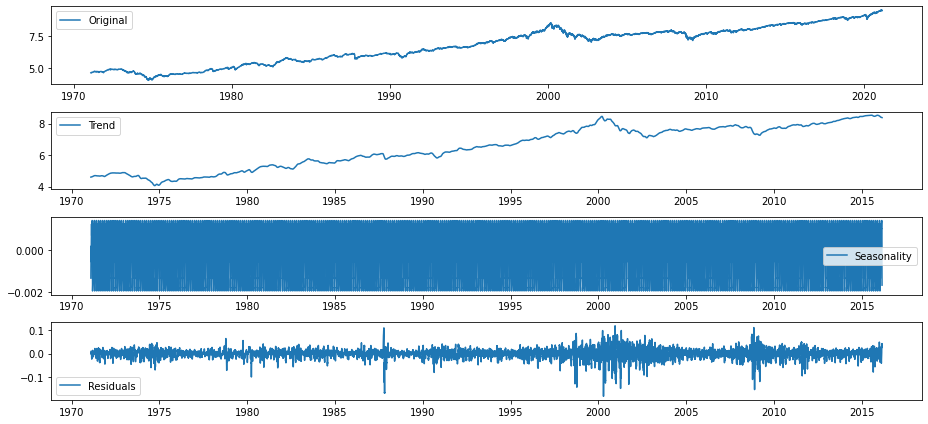

In [218]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data, model='additve', period = 30, extrapolate_trend = 1)
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [219]:
trend

Date
1971-02-05    4.607215
1971-02-08    4.608778
1971-02-09    4.610341
1971-02-10    4.611904
1971-02-11    4.613467
                ...   
2016-02-17    8.390912
2016-02-18    8.389301
2016-02-19    8.387691
2016-02-22    8.386080
2016-02-23    8.384469
Name: trend, Length: 11364, dtype: float64

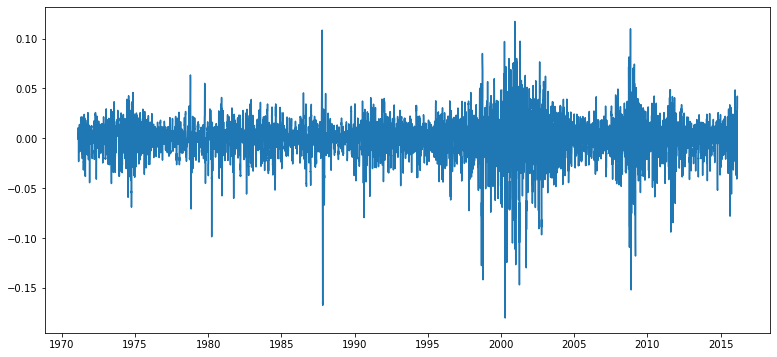

In [220]:
plt.plot(residual)

In [221]:
# ts = ts.interpolate(method = 'time')
residual[residual.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: resid, dtype: float64)

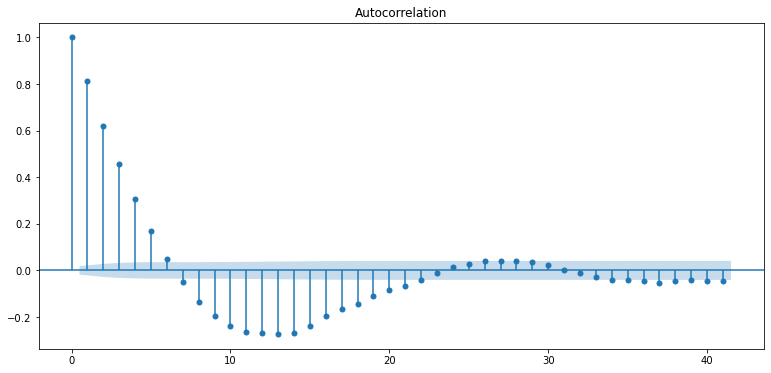

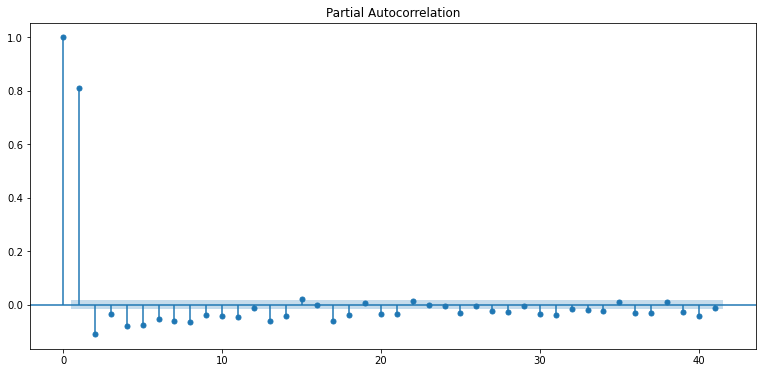

In [222]:
plot_acf(residual)
plot_pacf(residual)
plt.show()

만약 residual에 대해서 arima 모델을 적합시킨다면 pacf와 acf를 봤을때 ar(1)이 적절해보입니다. 

하지만 사실 pacf, acf를 통해서 arima모델의 패러미터를 구하는 방법은 연구자의 감으로 결정하는 것이기 때문에         
사용하기 어렵기도 합니다. 그렇기 때문에 AIC,BIC를 계산하여 패러미터를 지정하기도하고

예측력에 초점을 둔다면 TEST data을 대상으로 가장 좋은 성능을 보인 패러미터를 지정하기도합니다.                   
이번 제 노드의 목적은 예측이기때문에 가장 낮은 MAPE를 보인 패러미터를 지정하도록 하겠습니다.

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



### power transformation 사용 

분산을 안정화시키고 정규분포에 가깝게 근사시키기 위해서 사용하는 power함수를 사용하는 단조함수들을 통한 변환입니다.        
log변환 역시 일종의 power transforamtion이라고 볼 수 있습니다.

[위키디피아](https://en.wikipedia.org/wiki/Power_transform)

[scipy boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
[scipy boxcox의 인버스](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html)

In [223]:
from scipy.stats import boxcox

In [224]:
ts

Date
1971-02-05      100.000000
1971-02-08      100.839996
1971-02-09      100.760002
1971-02-10      100.690002
1971-02-11      101.449997
                  ...     
2021-02-23    13465.200195
2021-02-24    13597.969727
2021-02-25    13119.429688
2021-02-26    13192.349609
2021-03-01    13509.893555
Name: Close, Length: 12627, dtype: float64

In [225]:
powerd  = boxcox(ts)
ts_power, lamda = powerd
print(type(ts_power))
print(ts_power)

len(ts_power)

<class 'numpy.ndarray'>
[ 5.2485128   5.25932141  5.25829576 ... 12.48530839 12.49470063
 12.53503757]


12627

In [226]:
ts_power = pd.Series(ts_power, index = ts.index)
ts_power

Date
1971-02-05     5.248513
1971-02-08     5.259321
1971-02-09     5.258296
1971-02-10     5.257398
1971-02-11     5.267117
                ...    
2021-02-23    12.529415
2021-02-24    12.546067
2021-02-25    12.485308
2021-02-26    12.494701
2021-03-01    12.535038
Length: 12627, dtype: float64

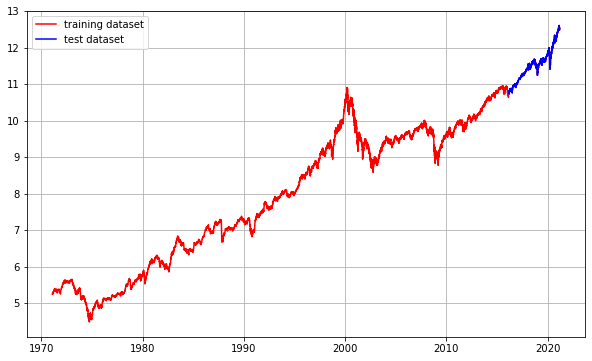

In [227]:
train_data, test_data = ts_power[ : int(len(ts_power)*0.90)],ts_power[int(len(ts_power)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_power, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

사실 안타깝게도 대부분의 데이터에서 box-cox transformation 변환이
아래의 log 변환보다 성능이 좋지않았습니다. 

그러므로 아래에서는 사용하지않곘습니다.

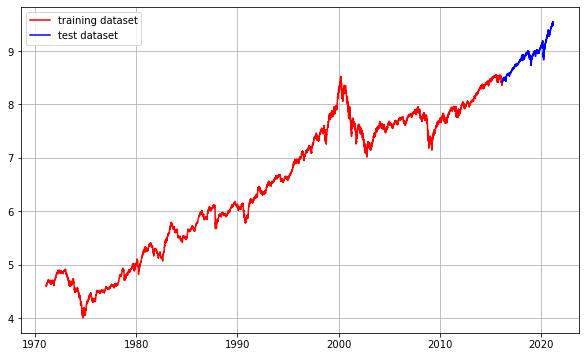

In [228]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.90)],ts_log[int(len(ts_log)* 0.90 ): ]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

### exog 변수 추가 

높은 정확도를 위해서 외래변수를 추가합니다. 저는 종가 데이터를 예측하기위해서
시가 데이터를 exog로 추가하도록하겠습니다.

In [229]:
Open = df['Open']
# Open = np.log(Open)
open_train, open_test = Open[ : int(len(ts_power)*0.90)]  , Open[int(len(ts_power)* 0.90 ): ]
open_train = open_train.interpolate(method = 'time')
open_test = open_test.interpolate(mothod = 'time')

In [230]:
train_data = train_data.interpolate(method = 'time')

In [231]:
open_test[open_test.isna()]


Series([], Name: Open, dtype: float64)

In [232]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (4,0,4), exog = open_train)
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                11364
Model:                     ARMA(4, 4)   Log Likelihood               34073.740
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 02 Mar 2021   AIC                         -68125.480
Time:                        04:18:17   BIC                         -68044.760
Sample:                             0   HQIC                        -68098.329
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.3479      2.539      2.500      0.012       1.371      11.325
Open            0.0001      5e-06     25.637      0.000       0.000       0.000
ar.L1.Close    -0.4201      0.001   -833.877    

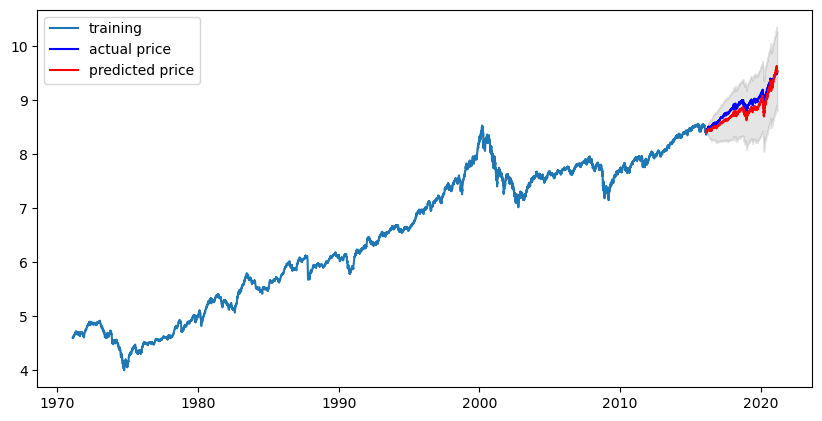

In [233]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(open_test), alpha = 0.05, exog = open_test) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [234]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))


mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  671923.1177067747
MAE:  753.926632103678
RMSE:  819.7091665382147
MAPE: 9.92%


exog 변수 덕분에 좋은 성능을 보일 수 있었습니다.

``` python
mape = np.mean(np.abs(  (inv_boxcox(fc, lamda) - inv_boxcox(test_data, lamda)) / inv_boxcox(fc, lamda)))
# print('MAPE: {:.2f}%'.format(mape*100))
```

의 코드는 시계열 데이터를 box-cox 변환 했을때의 MAPE를 계산하기 위해 만들어놓은 식입니다.

# 소고


### MAPE 잡기 
주식 시장의 변동이 너무 커서 단순 arima로는 도저히 MAPE를 잡을수가 없었습니다.
그래서 exog 변수를 넣었는데 너무 꼼수로 해결한거같아서 마음이 편치않습니다.
사실 exog를 넣으려면 애초에 log변환을 하지않고 그대로 넣으면 MAPE를 1%대 이내로 잡을 수 있는데
시계열 모델식은 log변환을 하고 넣고 exog데이터는 원본 데이터를 그대로 넣다보니 MAPE가 높게 나왔습니다.
이번 노드 평가기준에서 MAPE 10은 너무 높은 수치인거같습니다.. 올해 주식시장이 요동치는데 단순 ARIMA모델로 예측하기엔
TREND나 SEASONALITY 데이터가 너무 부족한거같습니다. 

### SARIMA
계절성을 고려하는 SARIMA나  분산을 고려하는 GARCH 같은 다른 모델을 사용하고 싶었는데 시간이 많이 부족했습니다. 


### BOX-COX 변환
POWER TRANSFORMATION을 통해서 변형을 해보았는데 사실 LOG보다 결과가 대부분 좋지않았습니다.
